In [1]:
# Import modules
from __future__ import print_function
import tensorflow as tf
import numpy as np
import time
import matplotlib.pyplot as plt
from ecbm4040.cifar_utils import load_data

# Plot configurations
% matplotlib inline

# Notebook auto reloads code. (Ref: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython)
% load_ext autoreload
% autoreload 2

In [2]:
# Load the raw CIFAR-10 data.
X_train, y_train, X_test, y_test = load_data()
X_train = X_train.reshape([50000,3,32,32]).transpose((0,2,3,1))
X_test = X_test.reshape([10000,3,32,32]).transpose((0,2,3,1))
# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

# Data organizations:
# Train data: 49000 samples from original train set: 1~49000
# Validation data: 1000 samples from original train set: 49000~50000
# Test data: 10000 samples from original test set: 1~10000
# Development data (for gradient check): 100 from the train set: 1~49000 #TODOTA is this 100 or 1000?
num_training = 49000
num_validation = 1000
num_dev = 100

X_val = X_train[-num_validation:]
y_val = y_train[-num_validation:]

mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

X_train = X_train[:num_training]
y_train = y_train[:num_training]

# Preprocessing: subtract the mean value across every dimension for training data
mean_image = np.mean(X_train, axis=0)

X_train = X_train.astype(np.float32) - mean_image.astype(np.float32)
X_val = X_val.astype(np.float32) - mean_image
X_test = X_test.astype(np.float32) - mean_image
X_dev = X_dev.astype(np.float32) - mean_image

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('Development data shape:', X_dev.shape)
print('Development data shape', y_dev.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)
(49000, 32, 32, 3) (1000, 32, 32, 3) (10000, 32, 32, 3) (100, 32, 32, 3)
Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)
Development data shape: (100, 32, 32, 3)
Development data shape (100,)


In [3]:
X_patch = X_train[:,:,:,0]
X_patch = np.reshape(X_patch, (X_patch.shape[0], -1))

In [4]:
X_patch.shape

(49000, 1024)

In [5]:
np.mean(X_patch)

-4.714343e-06

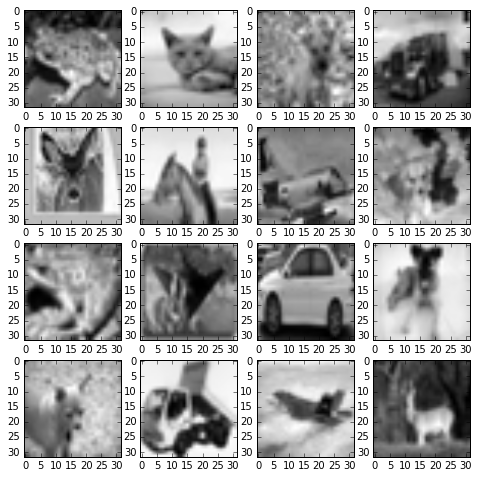

In [6]:
# Select a small set of images for test
num_training = 50000
num_pca = 16
mask = np.random.choice(num_training, num_pca, replace=False)
X_pca = X_train[mask,:,:,0]

# Visualize one channel of images 
r = 4
f, axarr = plt.subplots(r, r, figsize=(8,8))
for i in range(r):
    for j in range(r):
        img = X_pca[r*i+j]
        axarr[i][j].imshow(img, cmap="gray")

In [7]:
img = X_pca[0]

In [8]:
y = np.reshape(img, (-1,))

In [9]:
y.shape

(1024,)

In [13]:
X_cov /= (X_patch.shape[0] -1)

In [14]:
eig_values, eig_vectors = np.linalg.eig(X_cov)

In [16]:
len(eig_values)

1024

In [38]:
eiginds = eig_values.argsort()
sorted_eig_values = eig_values[eiginds[::-1]]
sorted_eig_vecs = (eig_vectors.transpose()[eiginds[::-1]]).transpose()

In [41]:
eig_vals = sorted_eig_values
tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in eig_vals]
cum_var_exp = np.cumsum(var_exp)

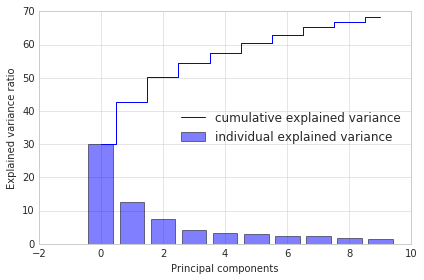

In [47]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))

    plt.bar(range(10), var_exp[:10], alpha=0.5, align='center',
            label='individual explained variance')
    plt.step(range(10), cum_var_exp[:10], where='mid',
             label='cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()

In [50]:
k = 200
req_dim = sorted_eig_vecs[:, :k]

In [51]:
P = X_patch.dot(req_dim)

In [54]:
req_dim.shape

(1024, 200)

In [49]:
arr1 = np.array([4,5,2,8,1,6])
arr2_t = np.array([[4,4,4,4,4,4],[5,5,5,5,5,5],[2,2,2,2,2,2],[8,8,8,8,8,8],[1,1,1,1,1,1],[6,6,6,6,6,6]])
arr2 = arr2_t.transpose()

In [25]:
arr2

array([[4, 5, 2, 8, 1, 6],
       [4, 5, 2, 8, 1, 6],
       [4, 5, 2, 8, 1, 6],
       [4, 5, 2, 8, 1, 6],
       [4, 5, 2, 8, 1, 6],
       [4, 5, 2, 8, 1, 6]])

In [35]:
arr1inds = arr1.argsort()
sorted_arr1 = arr1[arr1inds[::-1]]
sorted_arr2 = (arr2.transpose()[arr1inds[::-1]]).transpose()

In [36]:
sorted_arr1

array([8, 6, 5, 4, 2, 1])

In [37]:
sorted_arr2

array([[8, 6, 5, 4, 2, 1],
       [8, 6, 5, 4, 2, 1],
       [8, 6, 5, 4, 2, 1],
       [8, 6, 5, 4, 2, 1],
       [8, 6, 5, 4, 2, 1],
       [8, 6, 5, 4, 2, 1]])

In [29]:
arr1inds

array([4, 2, 0, 1, 5, 3])